In [ ]:
!pip install blitz-bayesian-pytorch


In [ ]:
import warnings
warnings.filterwarnings('ignore')


In [ ]:
import matplotlib.pyplot as plt
import math
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import seaborn as sns
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator
from torch.utils.data import TensorDataset, DataLoader
from matplotlib.pyplot import scatter, figure
from scipy import stats
from numpy.ma.core import outer
from sys import stderr


In [ ]:
start = -7
end = 7
n = 300
batch_size = 16

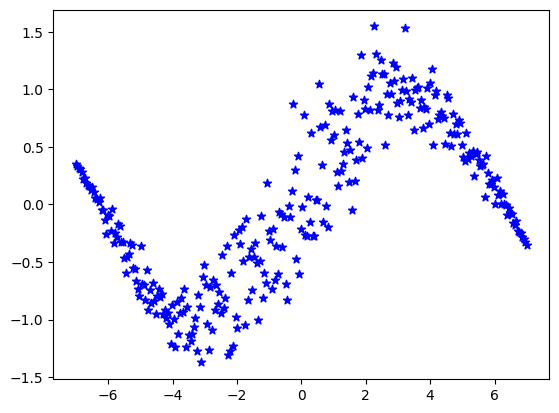

In [ ]:
def sample_dataset(start, end, n):
    np.random.seed(0)
    x = np.linspace(start, end, n)
    sample_mean = [math.sin(i/2) for i in x]

    sample_var = [abs((abs(start)+abs(end))/2 - abs(i))/16 for i in x]
    y = stats.norm(sample_mean, sample_var).rvs(random_state=0)
    return x, y

x_train, y_train = sample_dataset(start, end, n)
scatter(x_train, y_train, c="blue", marker="*")

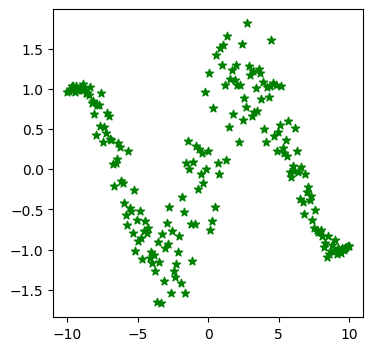

In [ ]:
figure(figsize=(4, 4))
# Not exactely the same distribution, but works for now
x_test, y_test = sample_dataset(-10, 10, 200)
scatter(x_test, y_test, c="green", marker="*")

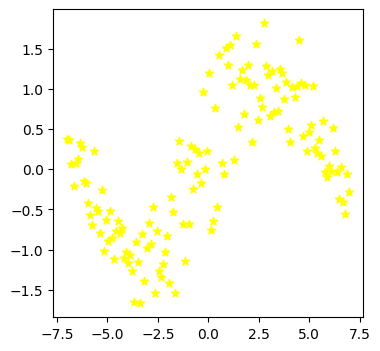

In [ ]:
#Plotting In Training Distribution Data Points in the Test Set
# Filter the data to retain only the desired ranges
mask =  (x_test >= -7) &  (x_test <= 7) # Select the ranges -10 to -7 and 7 to 10
x_test_idd = x_test[mask]
y_test_idd = y_test[mask]

plt.figure(figsize=(4, 4))
plt.scatter(x_test_idd, y_test_idd, c="yellow", marker="*")

plt.show()


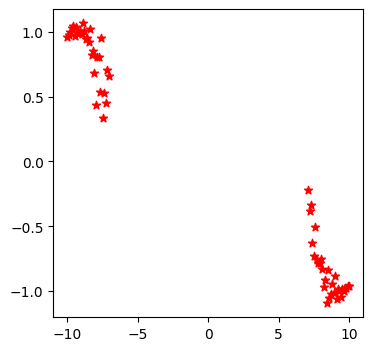

In [ ]:
#Plotting Out of Training Distribution Data Points in the Test Set
# Filter the data to retain only the desired ranges
mask = (x_test >= -10) & (x_test < -7) | (x_test > 7) & (x_test <= 10) # Select the ranges -10 to -7 and 7 to 10
x_test_oodd = x_test[mask]
y_test_oodd = y_test[mask]

plt.figure(figsize=(4, 4))
plt.scatter(x_test_oodd, y_test_oodd, c="red", marker="*")

plt.show()


In [ ]:

# Train
tensor_x = torch.Tensor(x_train).unsqueeze(1)
tensor_y = torch.Tensor(y_train).unsqueeze(1)
train_dataset = TensorDataset(tensor_x, tensor_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#Test for OODD (Out of Data Distribution)
tensor_x_test_oodd = torch.Tensor(x_test_oodd).unsqueeze(1)
tensor_y_test_oodd = torch.Tensor(y_test_oodd).unsqueeze(1)
test_dataset_oodd = TensorDataset(tensor_x_test_oodd, tensor_y_test_oodd)
test_loader_oodd = DataLoader(test_dataset_oodd, batch_size=batch_size, shuffle=True)

#Test for IDD (In Data Distribution)
tensor_x_test_idd = torch.Tensor(x_test_idd).unsqueeze(1)
tensor_y_test_idd = torch.Tensor(y_test_idd).unsqueeze(1)
test_dataset_idd = TensorDataset(tensor_x_test_idd, tensor_y_test_idd)
test_loader_idd = DataLoader(test_dataset_idd, batch_size=batch_size, shuffle=True)

# Test
tensor_x_test = torch.Tensor(x_test).unsqueeze(1)
tensor_y_test = torch.Tensor(y_test).unsqueeze(1)
test_dataset = TensorDataset(tensor_x_test, tensor_y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
class MCDO(nn.Module):
    def __init__(self):
        super(MCDO, self).__init__()
        hidden_size = 61

        # We only have 1 input feature
        self.fc1 = nn.Linear(1, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, x):
        h = self.dropout(torch.relu(self.fc1(x)))
        h = self.dropout(torch.relu(self.fc2(h)))
        out = self.out(h)
        return out



In [ ]:
model = MCDO()
print(model)
print("Params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

MCDO(
  (fc1): Linear(in_features=1, out_features=61, bias=True)
  (fc2): Linear(in_features=61, out_features=61, bias=True)
  (out): Linear(in_features=61, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
Params: 3966


In [ ]:
def make_plot_mcdo(model, samples = 50):
    # Keep dropout active!
    model.train()
    preds = [model(tensor_x_test) for i in range(samples)]
    preds = torch.stack(preds)
    means = preds.mean(axis=0).detach().numpy()
    stds =  preds.std(axis=0).detach().numpy()
    dfs = []
    y_vals = [means, means+2*stds, means-2*stds]

    for i in range(3):
      data = {
            "x": list(tensor_x_test.squeeze().numpy()),
            "y": list(y_vals[i].squeeze())
      }
      temp = pd.DataFrame.from_dict(data)
      dfs.append(temp)

    df = pd.concat(dfs).reset_index()

    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")

    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)

    # Plot test data on top
    scatter(x_test, y_test, c="green", marker="*", alpha=0.1)
    plt.show()

In [ ]:
def make_plot_mcdo_oodd(model, samples = 50):
    # Keep dropout active!
    model.train()
    preds = [model(tensor_x_test_oodd) for i in range(samples)]
    preds = torch.stack(preds)
    means = preds.mean(axis=0).detach().numpy()
    stds =  preds.std(axis=0).detach().numpy()
    dfs = []
    y_vals = [means, means+2*stds, means-2*stds]

    for i in range(3):
      data = {
            "x": list(tensor_x_test_oodd.squeeze().numpy()),
            "y": list(y_vals[i].squeeze())
      }
      temp = pd.DataFrame.from_dict(data)
      dfs.append(temp)

    df = pd.concat(dfs).reset_index()

    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")

    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)

    # Plot train data on top
    scatter(x_test_oodd, y_test_oodd, c="red", marker="*", alpha=0.1)
    plt.show()

In [ ]:
def make_plot_mcdo_idd(model, samples = 50):
    # Keep dropout active!
    model.train()
    preds = [model(tensor_x_test_idd) for i in range(samples)]
    preds = torch.stack(preds)
    means = preds.mean(axis=0).detach().numpy()
    stds =  preds.std(axis=0).detach().numpy()
    dfs = []
    y_vals = [means, means+2*stds, means-2*stds]

    for i in range(3):
      data = {
            "x": list(tensor_x_test_idd.squeeze().numpy()),
            "y": list(y_vals[i].squeeze())
      }
      temp = pd.DataFrame.from_dict(data)
      dfs.append(temp)

    df = pd.concat(dfs).reset_index()

    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")

    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)

    # Plot train data on top
    scatter(x_test_idd, y_test_idd, c="yellow", marker="*", alpha=0.1)
    plt.show()

In [ ]:
def MLE_mcdo():
  criterion = torch.nn.MSELoss()
  model = MCDO()
  optimizer = optim.Adam(model.parameters(), lr=0.01)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  model.to(device)

  for epoch in range(150):
    model.train()
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(y, out)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        all_test_losses = []
        # Test loop
        for batch in test_loader:
             x = batch[0].to(device)
             y = batch[1].to(device)

             # Sample MC Dropout predictions
             outs = []
             for i in range(10):
                  model.train()
                  out = model(x)
                  outs.append(out)

             # Take mean prediction
             out = sum(outs)/len(outs)
             all_test_losses.append(criterion(y, out).item())
        test_loss = sum(all_test_losses)/len(all_test_losses)

  make_plot_mcdo(model)
  print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")

  return loss, test_loss


In [ ]:
def MLE_mcdo_oodd():
  criterion = torch.nn.MSELoss()
  model = MCDO()
  optimizer = optim.Adam(model.parameters(), lr=0.01)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  model.to(device)

  for epoch in range(150):
    model.train()
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(y, out)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        all_test_losses = []
        # Test loop
        for batch in test_loader_oodd:
             x = batch[0].to(device)
             y = batch[1].to(device)

             # Sample MC Dropout predictions
             outs = []
             for i in range(10):
                  model.train()
                  out = model(x)
                  outs.append(out)

             # Take mean prediction
             out = sum(outs)/len(outs)
             all_test_losses.append(criterion(y, out).item())
        test_loss = sum(all_test_losses)/len(all_test_losses)

  make_plot_mcdo_oodd(model)
  print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")

  return loss, test_loss


In [ ]:
def MLE_mcdo_idd():
  criterion = torch.nn.MSELoss()
  model = MCDO()
  optimizer = optim.Adam(model.parameters(), lr=0.01)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  model.to(device)

  for epoch in range(150):
    model.train()
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(y, out)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        all_test_losses = []
        # Test loop
        for batch in test_loader_idd:
             x = batch[0].to(device)
             y = batch[1].to(device)

             # Sample MC Dropout predictions
             outs = []
             for i in range(10):
                  model.train()
                  out = model(x)
                  outs.append(out)

             # Take mean prediction
             out = sum(outs)/len(outs)
             all_test_losses.append(criterion(y, out).item())
        test_loss = sum(all_test_losses)/len(all_test_losses)

  make_plot_mcdo_idd(model)
  print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")

  return loss, test_loss


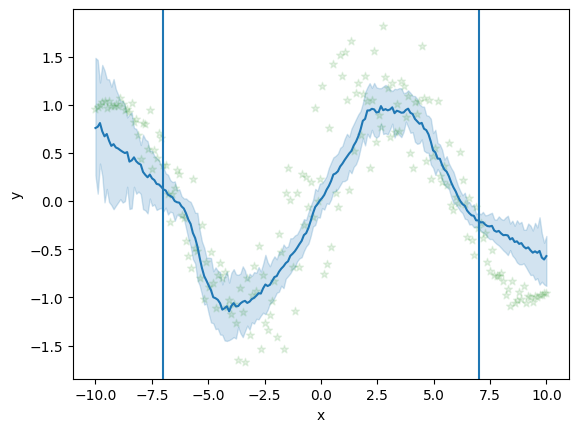

Epoch 149 | batch train loss: 0.05906073749065399 | test loss: 0.16573534103540274


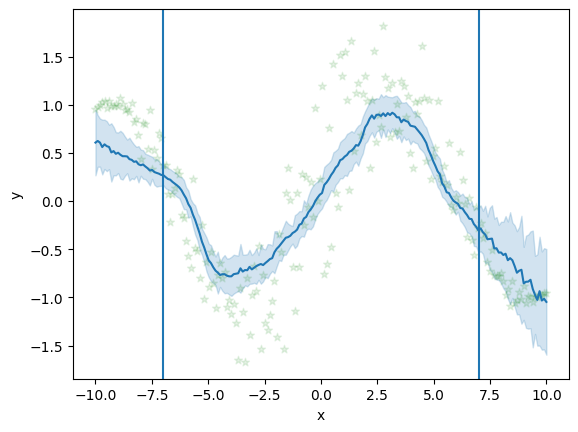

Epoch 149 | batch train loss: 0.13973833620548248 | test loss: 0.2492988986464647


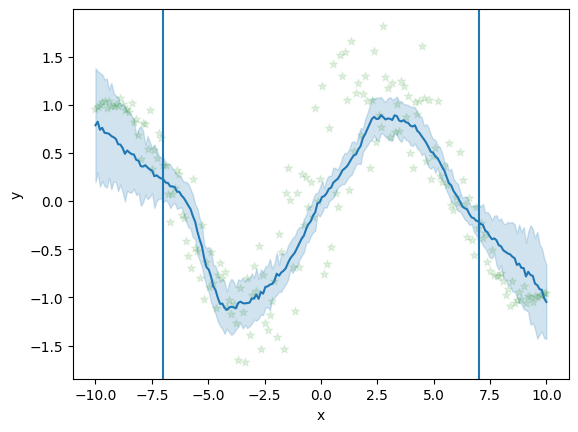

Epoch 149 | batch train loss: 0.1737252026796341 | test loss: 0.18286377993913797


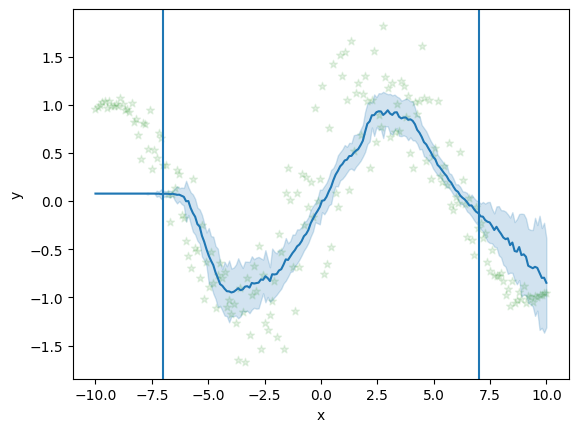

Epoch 149 | batch train loss: 0.03443518280982971 | test loss: 0.2659337360125322


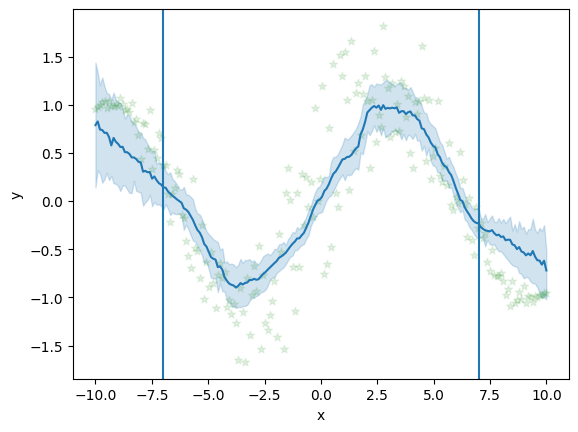

Epoch 149 | batch train loss: 0.08212422579526901 | test loss: 0.19145027146889612


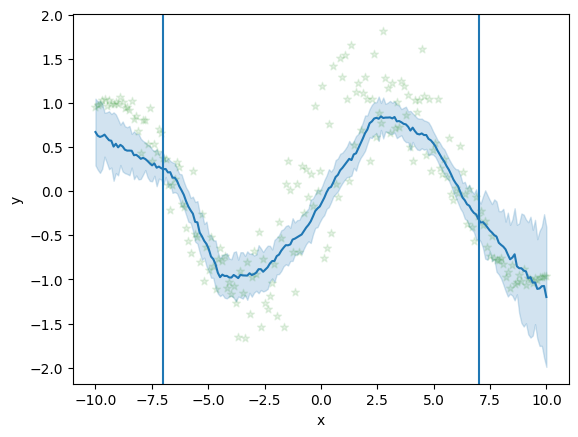

Epoch 149 | batch train loss: 0.04006350040435791 | test loss: 0.20980188307853845


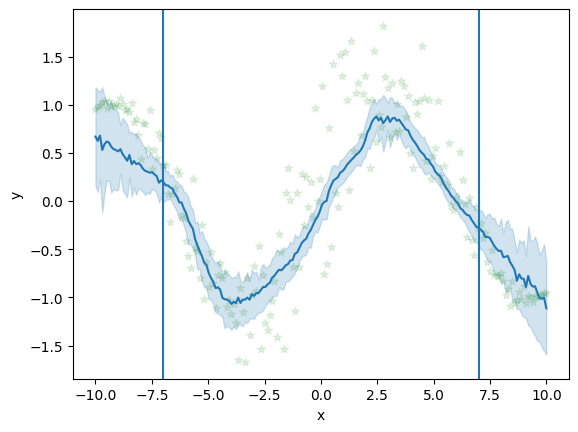

Epoch 149 | batch train loss: 0.0736340805888176 | test loss: 0.19331145859681642


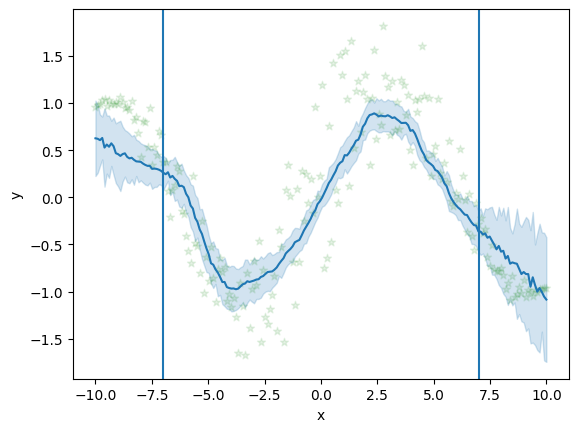

Epoch 149 | batch train loss: 0.0445510596036911 | test loss: 0.19930349233058783


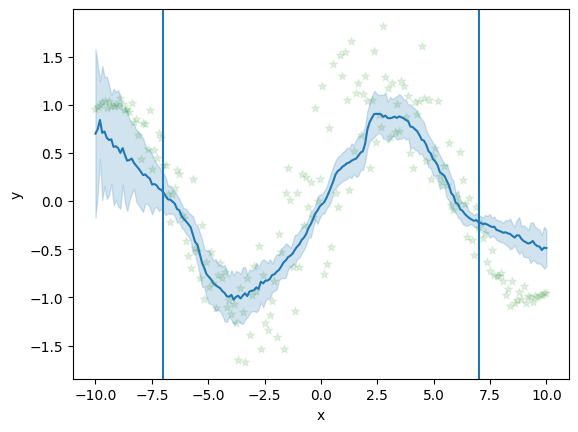

Epoch 149 | batch train loss: 0.04742107912898064 | test loss: 0.17461737531882066


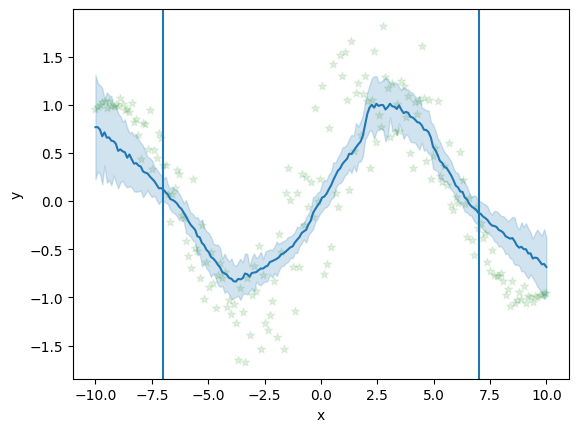

Epoch 149 | batch train loss: 0.11100593954324722 | test loss: 0.1569657729795346


In [ ]:
train_losses=[]
test_losses=[]

for i in range(10):
  tr_loss,test_loss = MLE_mcdo()
  train_losses.append(tr_loss)
  test_losses.append(test_loss)


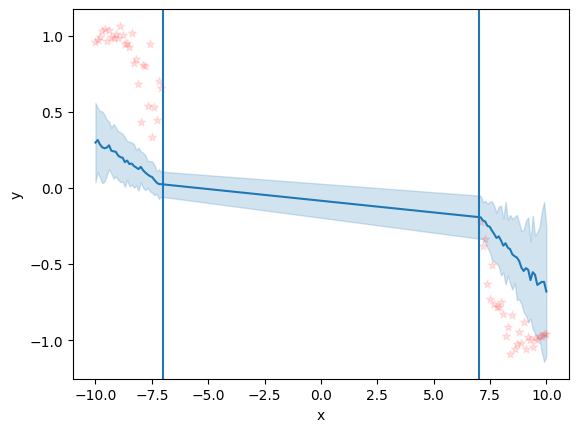

Epoch 149 | batch train loss: 0.04380975663661957 | test loss: 0.13789564557373524


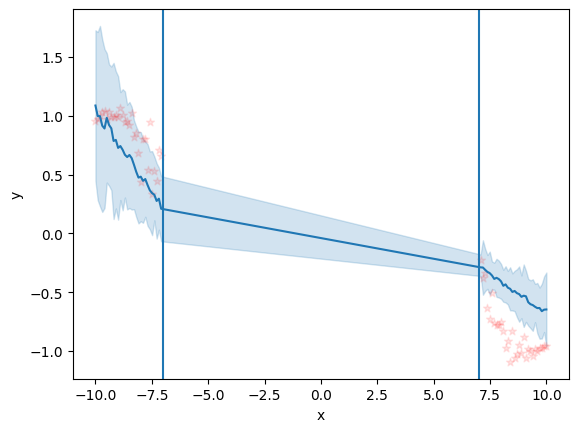

Epoch 149 | batch train loss: 0.04405802860856056 | test loss: 0.19365036860108376


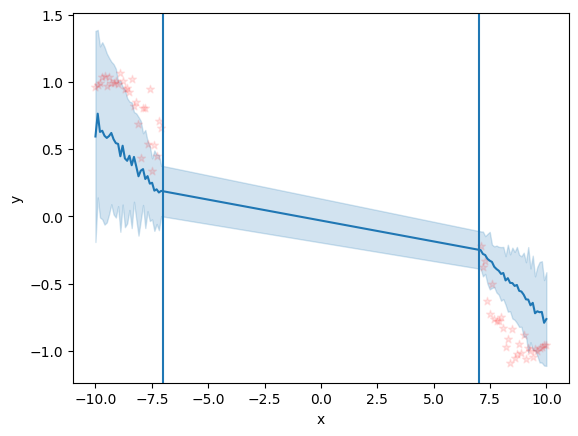

Epoch 149 | batch train loss: 0.09908998012542725 | test loss: 0.11181203834712505


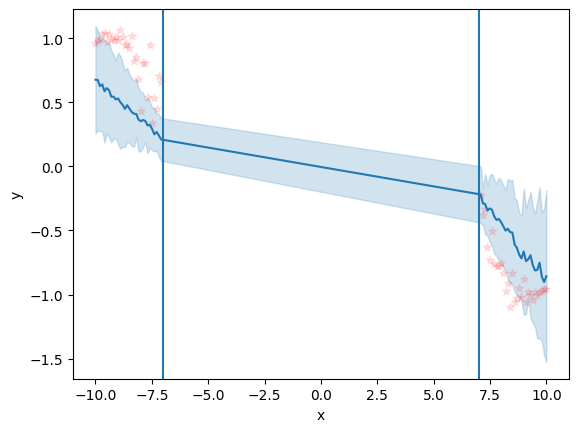

Epoch 149 | batch train loss: 0.0777413547039032 | test loss: 0.2570091262459755


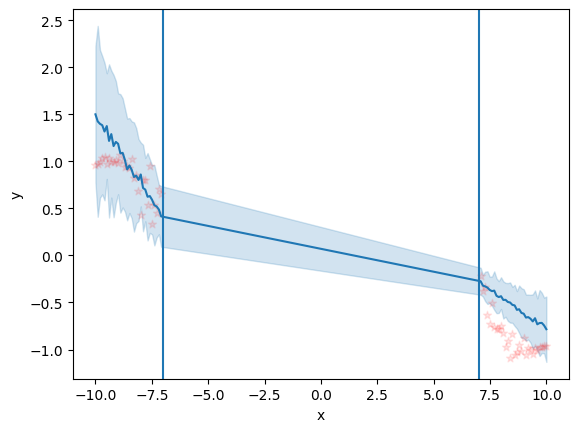

Epoch 149 | batch train loss: 0.07613445073366165 | test loss: 0.07751300651580095


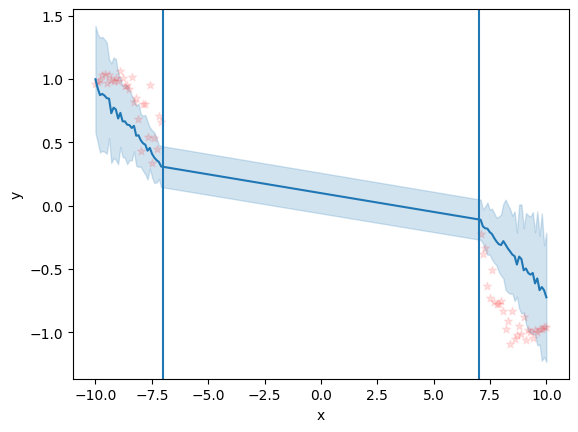

Epoch 149 | batch train loss: 0.1169632151722908 | test loss: 0.16423781961202621


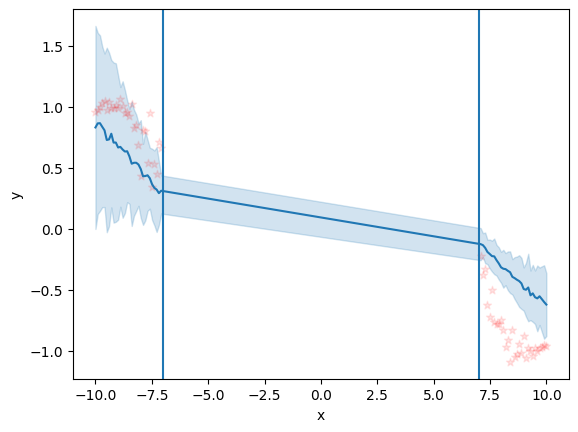

Epoch 149 | batch train loss: 0.03991485759615898 | test loss: 0.11405852064490318


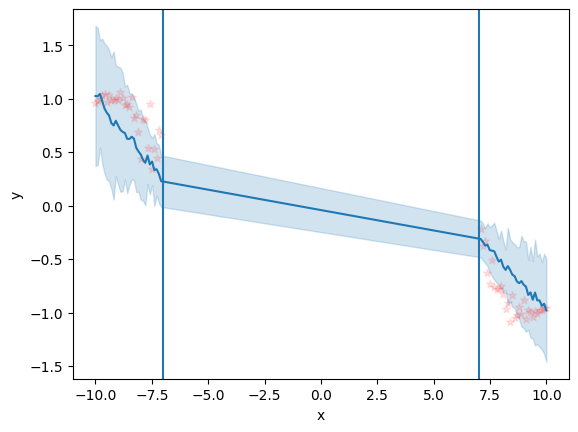

Epoch 149 | batch train loss: 0.07628070563077927 | test loss: 0.12714187055826187


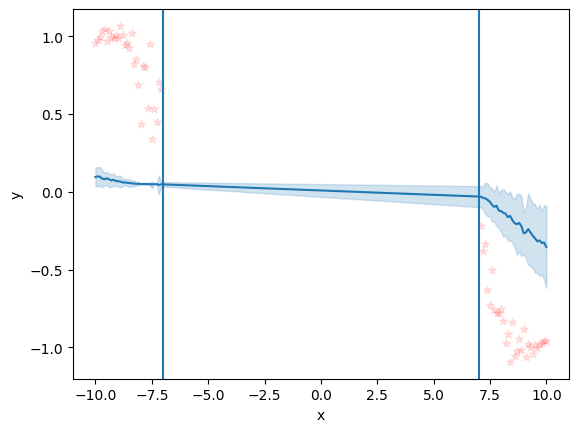

Epoch 149 | batch train loss: 0.1030280590057373 | test loss: 0.11800764873623848


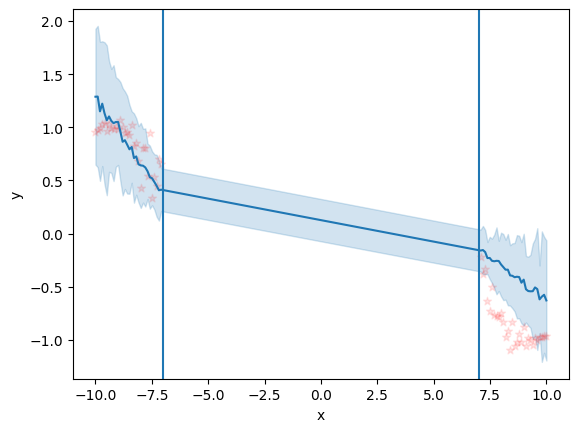

Epoch 149 | batch train loss: 0.04841100051999092 | test loss: 0.20183523371815681


In [ ]:
train_losses_oodd=[]
test_losses_oodd=[]

for i in range(10):
  tr_loss,test_loss = MLE_mcdo_oodd()
  train_losses_oodd.append(tr_loss)
  test_losses_oodd.append(test_loss)


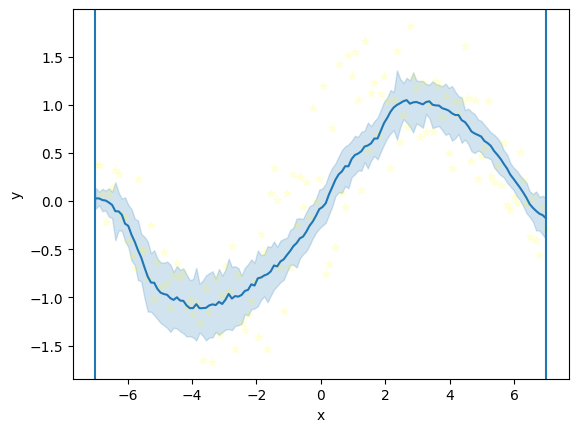

Epoch 149 | batch train loss: 0.04161910340189934 | test loss: 0.1927929570277532


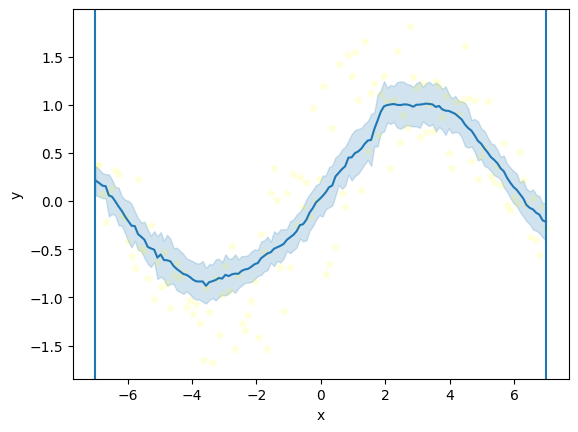

Epoch 149 | batch train loss: 0.12555067241191864 | test loss: 0.18729792286952338


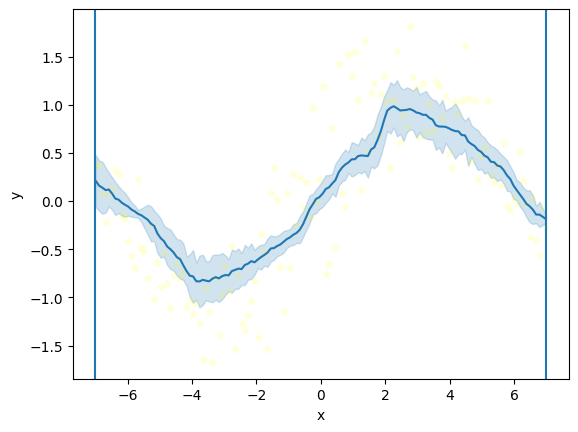

Epoch 149 | batch train loss: 0.03710594400763512 | test loss: 0.20285402403937447


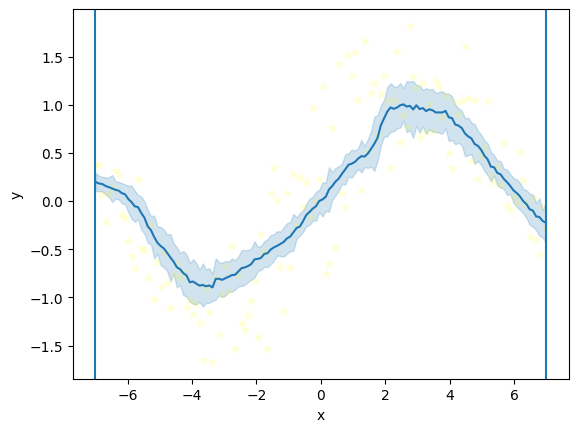

Epoch 149 | batch train loss: 0.11352794617414474 | test loss: 0.21334702976875836


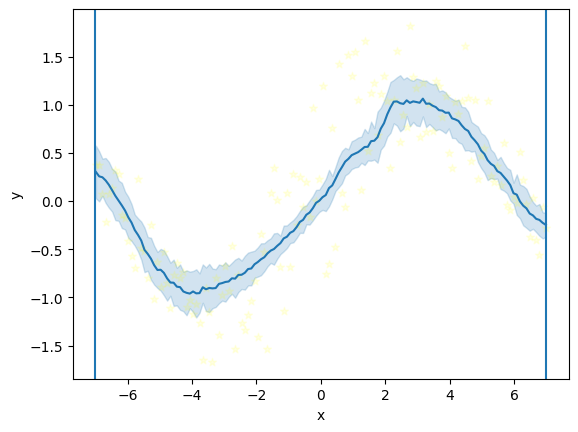

Epoch 149 | batch train loss: 0.13735322654247284 | test loss: 0.2173598094118966


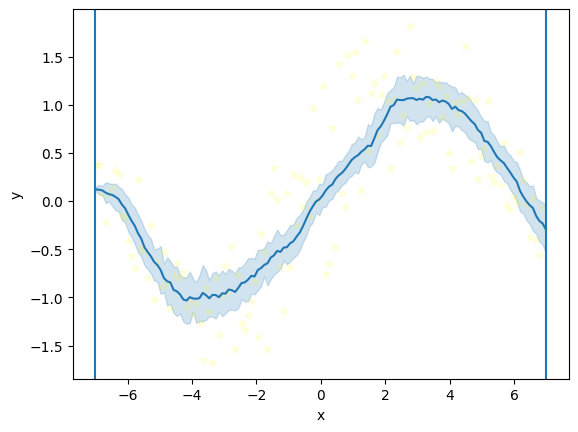

Epoch 149 | batch train loss: 0.10945525765419006 | test loss: 0.19430914024511972


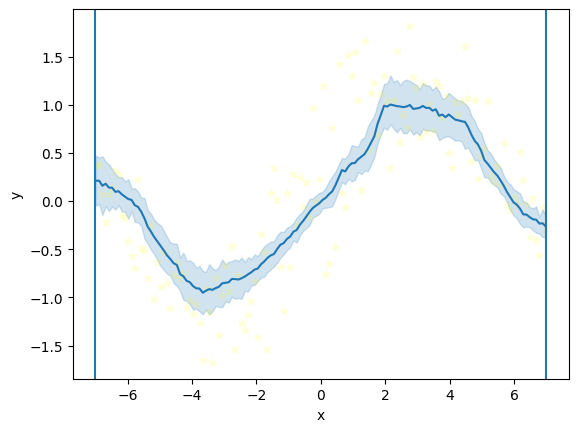

Epoch 149 | batch train loss: 0.07673374563455582 | test loss: 0.20893106112877527


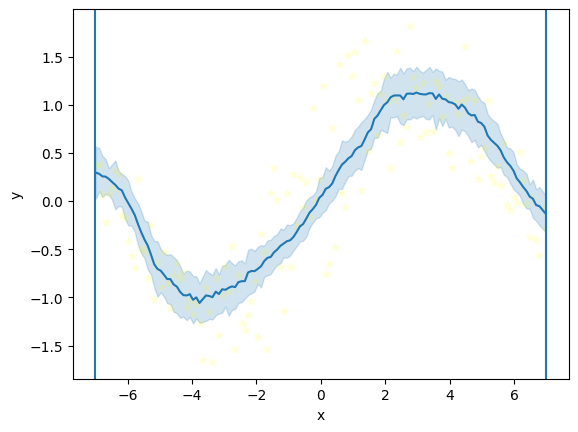

Epoch 149 | batch train loss: 0.05862624570727348 | test loss: 0.20734455933173498


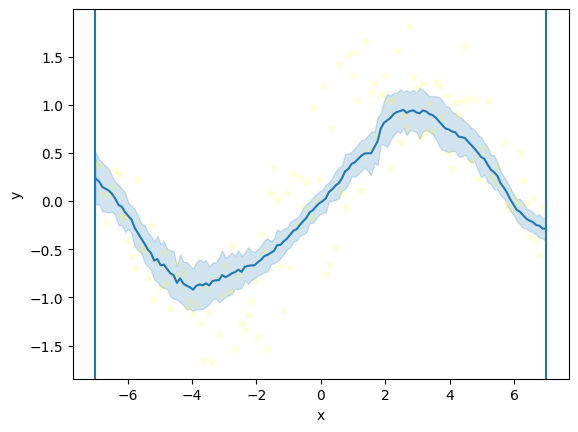

Epoch 149 | batch train loss: 0.06022701784968376 | test loss: 0.2036862216062016


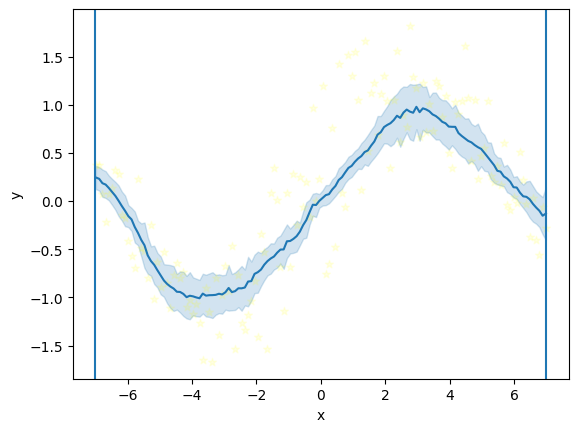

Epoch 149 | batch train loss: 0.0804016962647438 | test loss: 0.21272468980815676


In [ ]:
train_losses_idd=[]
test_losses_idd=[]

for i in range(10):
  tr_loss,test_loss = MLE_mcdo_idd()
  train_losses_idd.append(tr_loss)
  test_losses_idd.append(test_loss)


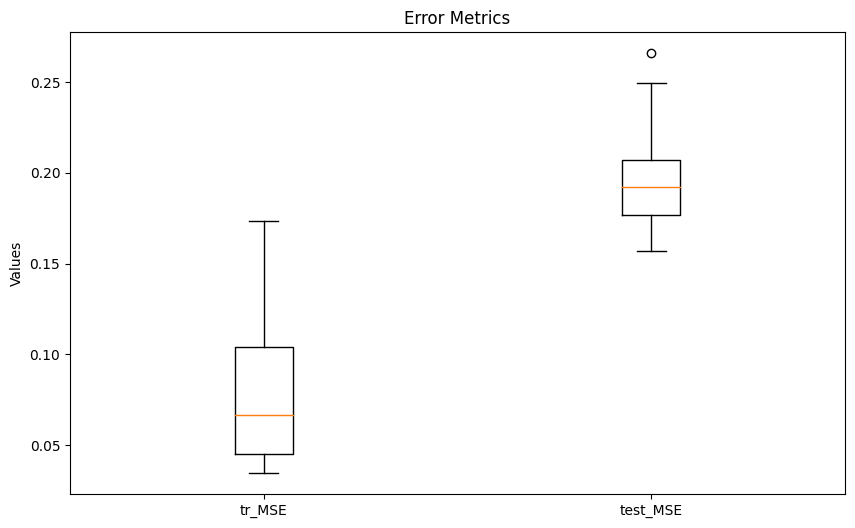

In [ ]:
# Extract numerical values from the tensors and remove grad_fn
tr_loss_values= [tensor.item() for tensor in train_losses]
test_loss_values=test_losses

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create box plots for each dataset
box_plot_data = [tr_loss_values, test_loss_values]
box_labels = ['tr_MSE', 'test_MSE']

ax.boxplot(box_plot_data, labels=box_labels)

# Add labels and title

ax.set_ylabel('Values')
ax.set_title('Error Metrics')

# Show the plot
plt.show()


In [ ]:

# mean_gaus_train_loss = np.mean(tr_loss_values)
# std_dev_gaus_train_loss = np.std(tr_loss_values)

# mean_gaus_test_loss = np.mean(test_loss_values)
# std_dev_gaus_test_loss = np.std(test_loss_values)

mean_mse_train = np.mean(tr_loss_values)
std_dev_mse_train = np.std(tr_loss_values)

mean_mse_test = np.mean(test_loss_values)
std_dev_mse_test = np.std(test_loss_values)

# print('Mean of Gausiann Training Loss of 10 runs ', mean_gaus_train_loss)
# print('Standard Deviation of Gausiann Training Loss of 10 runs ' , std_dev_gaus_train_loss )

# print('Mean of Gausiann Testing Loss of 10 runs ',mean_gaus_test_loss )
# print('Standard Deviation of Gausiann Testing Loss of 10 runs ',std_dev_gaus_test_loss)

print('Mean of MSE Training of 10 runs ',mean_mse_train)
print('Standard Deviation of MSE Training of 10 runs ' , std_dev_mse_train)

print('Mean of MSE Testing of 10 runs ',mean_mse_test )
print('Standard Deviation of MSE Testing of 10 runs ', std_dev_mse_test)

Mean of MSE Training of 10 runs  0.08057593442499637
Standard Deviation of MSE Training of 10 runs  0.04447888680909192
Mean of MSE Testing of 10 runs  0.19892820094067318
Standard Deviation of MSE Testing of 10 runs  0.03308245323710822


In [ ]:
# Create a DataFrame from the lists
data = {
    'Training MSE': tr_loss_values,
    'Testing MSE': test_loss_values,

}

num_columns = len(data)

column_names = ['Training MSE','Testing MSE']

# Create a DataFrame with dynamic column names
df = pd.DataFrame(data, columns=column_names)
df.index += 1
# Display the DataFrame as a table
print(df)
df.to_csv('results_mcdnn.csv', index=True)

    Training MSE  Testing MSE
1       0.059061     0.165735
2       0.139738     0.249299
3       0.173725     0.182864
4       0.034435     0.265934
5       0.082124     0.191450
6       0.040064     0.209802
7       0.073634     0.193311
8       0.044551     0.199303
9       0.047421     0.174617
10      0.111006     0.156966


In [ ]:
print(test_loss_values)

[0.16573534103540274, 0.2492988986464647, 0.18286377993913797, 0.2659337360125322, 0.19145027146889612, 0.20980188307853845, 0.19331145859681642, 0.19930349233058783, 0.17461737531882066, 0.1569657729795346]
